In [1]:
#Data Mining
#Author: Caroline Keller
#File: Midterm_CarolineKeller.ipynb

In [2]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import metrics
from sklearn import neighbors
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import GaussianNB

#Load dataset into dataframe
happinessRaw = pd.read_csv('worldHapinness_2015_2020.csv')

In [3]:
############## Cleaning ######################################################

#Review dataset
happinessRaw.info()

#Check dataset for null values & drop null values
print('# of null values: ', happinessRaw.isnull().sum().sum(), '\n')
happiness = happinessRaw.dropna()

#Review dataset to ensure null values have been properly removed
print(happiness.head(), '\n')
print('# of null values: ', happiness.isnull().sum().sum(), '\n')

#Rename feature labels
happiness = happiness.rename(columns={'Regional indicator': 'Regional_Indicator'})
print('RENAMED: \n', happiness.head(), '\n')

#Drop country column - country doesn't seem like a relevant feature for prediction & has no inherent ordinal meaning
happiness = happiness.drop(['country'], axis = 1)
print(happiness.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             935 non-null    object 
 1   Regional indicator  933 non-null    object 
 2   happinessScore      935 non-null    float64
 3   GDPperCap           935 non-null    float64
 4   socialSupport       935 non-null    float64
 5   healthLE            935 non-null    float64
 6   freedom             935 non-null    float64
 7   generosity          935 non-null    float64
 8   trustGovernment     934 non-null    float64
 9   year                935 non-null    int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 73.2+ KB
# of null values:  3 

       country Regional indicator  happinessScore  GDPperCap  socialSupport  \
0      Finland     Western Europe           7.769      1.340          1.587   
1      Denmark     Western Europe           7.600      1.383   

Text(0.5, 1.0, 'Freedom X Happiness Score')

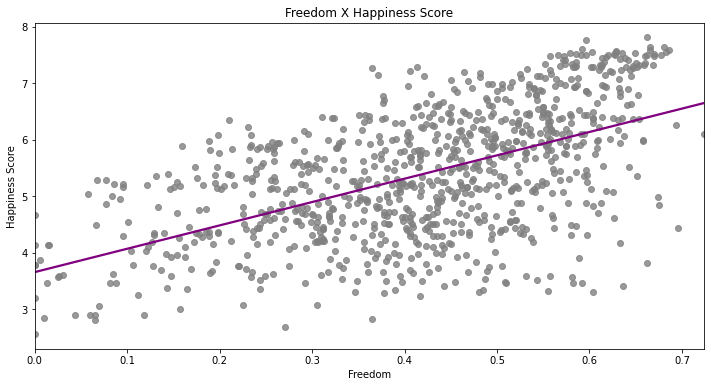

In [4]:
########### Preliminary Analysis ##############################################

#Plot freedom x happiness score 
plt.figure(figsize = (12,6))
lmplot = sns.regplot(x = 'freedom', y = 'happinessScore', data = happiness, ci=None, order=1, 
            scatter_kws = {'color': 'gray'}, line_kws = {'color': 'purple'})
plt.xlabel('Freedom')
plt.ylabel('Happiness Score')
plt.title('Freedom X Happiness Score')

#Takeaway: seems like there is a positive relationship between happiness and freedom but lots of variance

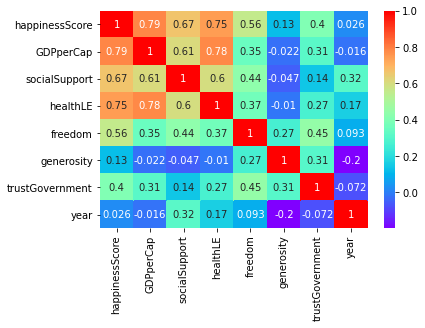

In [5]:
########### Preliminary Analysis ##############################################

#Plot correlation matrix
sns.heatmap(happiness.corr(), annot = True, cmap = 'rainbow')
plt.show()

#Takeaway: There may be some collinearity issues. GDPperCap is highly correlated with greater social supports and better health, 
# which makes sense as wealthier countries tend to have better social support infrastructure and higher life expectancies
# this provides insight into what variables to be cautious of when validating the model 

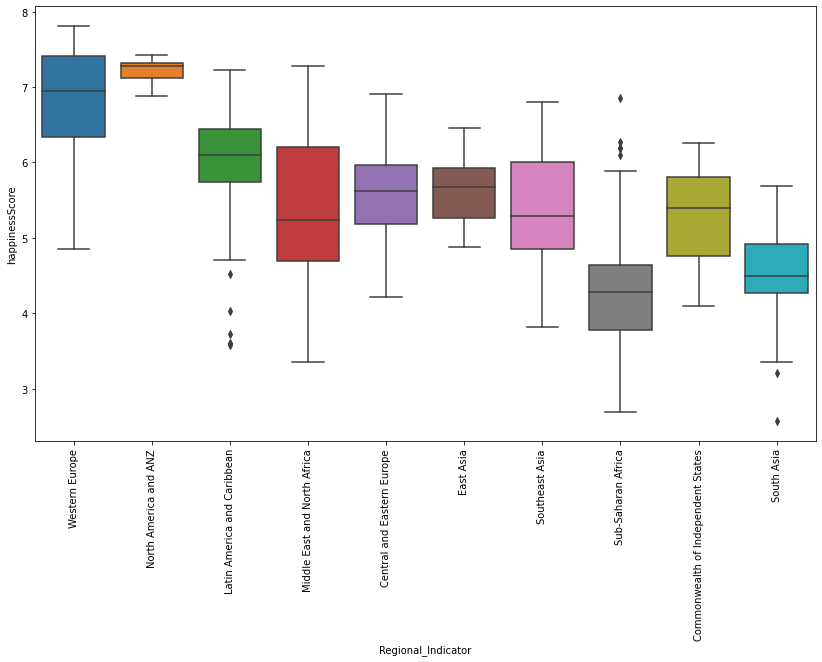

In [6]:
########### Preliminary Analysis ##############################################

#Examine distribution of "happiness" by region
plt.figure(figsize = (14,8))
b_plot = sns.boxplot(x = 'Regional_Indicator', y = 'happinessScore', data = happiness)
b_plot.tick_params(axis = 'x', rotation = 90)

#Takeaway: Some regions have a greater degree of variablity like the Middle East & North Africa
# and Sub-Saharan Afrcia. East Asia and North America & ANZ have a tighter range. Overall,
# Western Europe, North America & ANZ, and Latin America & Carribean have median happiness scores
# above 6

In [7]:
#Cleaning again because regional indicator might be useful for further analysis 

#Examine possible values in regional indicator column - convert to list & then set to pull unique values
regionList = set(happiness['Regional_Indicator'].tolist())
print('Region Groupings: ', regionList, '\n')

#Recode regional indicator - create dummy variables 
happiness = pd.get_dummies(happiness, columns = ['Regional_Indicator'], drop_first = True)
print('RECODED: \n', happiness.head(), '\n')          #Central and Eastern Europe is the base 

Region Groupings:  {'Sub-Saharan Africa', 'Central and Eastern Europe', 'Western Europe', 'North America and ANZ', 'Middle East and North Africa', 'Commonwealth of Independent States', 'East Asia', 'Latin America and Caribbean', 'Southeast Asia', 'South Asia'} 

RECODED: 
    happinessScore  GDPperCap  socialSupport  healthLE  freedom  generosity  \
0           7.769      1.340          1.587     0.986    0.596       0.153   
1           7.600      1.383          1.573     0.996    0.592       0.252   
2           7.554      1.488          1.582     1.028    0.603       0.271   
3           7.494      1.380          1.624     1.026    0.591       0.354   
4           7.488      1.396          1.522     0.999    0.557       0.322   

   trustGovernment  year  \
0            0.393  2019   
1            0.410  2019   
2            0.341  2019   
3            0.118  2019   
4            0.298  2019   

   Regional_Indicator_Commonwealth of Independent States  \
0                           

In [8]:
########## Splitting Data into Sets #####################################

#Extract 2020-specific data out of happiness df - 2020 data will become test set
print('# of 2020-specific rows: ', len(happiness[happiness['year'] == 2020]), '\n')

data_20 = happiness.loc[happiness['year'] == 2020]
print('data_20: ', len(data_20), '\n')
print(data_20.head(), '\n')

data_rem = happiness.loc[happiness['year'] != 2020]
print('data_rem: ', len(data_rem), '\n')
print(data_rem.head(), '\n')
#Validated data has been split accordingly

#Split data_rem df into training set
x_train = data_rem[data_rem.columns.difference(['happinessScore'])]
y_train = data_rem['happinessScore']
print(x_train, y_train, '\n')
print('# of rows & columns in x training set: ', x_train.shape, '\n')

#Split data_20 df into test set
x_test = data_20[data_20.columns.difference(['happinessScore'])]
y_test = data_20['happinessScore']
print(x_test, y_test, '\n')
print('# of rows & columns in x test set: ', x_test.shape, '\n')

# of 2020-specific rows:  153 

data_20:  153 

     happinessScore  GDPperCap  socialSupport  healthLE   freedom  generosity  \
782          7.8087   1.285190       1.499526  0.961271  0.662317    0.159670   
783          7.6456   1.326949       1.503449  0.979333  0.665040    0.242793   
784          7.5599   1.390774       1.472403  1.040533  0.628954    0.269056   
785          7.5045   1.326502       1.547567  1.000843  0.661981    0.362330   
786          7.4880   1.424207       1.495173  1.008072  0.670201    0.287985   

     trustGovernment  year  \
782         0.477857  2020   
783         0.495260  2020   
784         0.407946  2020   
785         0.144541  2020   
786         0.434101  2020   

     Regional_Indicator_Commonwealth of Independent States  \
782                                                  0       
783                                                  0       
784                                                  0       
785                                 

In [9]:
################ Model Selection ###############################################

#Model 1 : Linear Regression 

#Fit and train dataset on linear regression model 
lm = LinearRegression(normalize = True)
lm.fit(x_train, y_train)

#Determine train Rsquared and MSE
print('Training R-squared: {:.3f}'.format(lm.score(x_train, y_train)))
print('Training MSE: {:.3f}'.format(mean_squared_error(y_train, lm.predict(x_train))))
print('\n')

#Deterimine test Rsquared and MSE
print('Testing R-squared: {:.3f}'.format(lm.score(x_test, y_test)))
print('Testing MSE: {:.3f}'.format(mean_squared_error(y_test, lm.predict(x_test))))

Training R-squared: 0.818
Training MSE: 0.231


Testing R-squared: 0.765
Testing MSE: 0.289


In [10]:
#MSE is low and Rsquared is high on both training and test
#Next, try different variables to see if that impacts MSE & Rsquared using Subset Feature Selector 

#Create empty linear model and list 
CV_scores = []
model1 = LinearRegression()  

#Set up estimator that will select best features based on cross-validation
for i in range(1, len(x_train.columns)):
    print('# of Features: ', i)
    sfs = SequentialFeatureSelector(model1, 
                                n_features_to_select = i, 
                                direction = 'forward',
                                scoring = 'neg_mean_squared_error', 
                                cv = 10)    #Split into 10-k folds
    #Fit & train data to determine features from x that maximize performance
    sfs = sfs.fit(x_train, y_train)  
    #Print subset of features selected
    print('Features selected: ', list(x_train.columns[sfs.get_support()]))
    #Create subset of features & evaluate CV score
    score = cross_val_score(model1, sfs.transform(x_train), y_train, cv = 10, scoring = 'neg_mean_squared_error')
    cv_avg = abs(score.mean()) 
    #Save all CV errors in an array
    CV_scores.append(cv_avg)
    print(cv_avg, '\n')
    
#Determine model with the lowest CV error
minCV = min(CV_scores) 
print('Lowest CV Error:', minCV)
#Model with lowest CV error is the model with 15 features 

#Decided to drop regions because they don't seem to be useful predictors and muddy interpretation

# of Features:  1
Features selected:  ['GDPperCap']
0.5042052183518226 

# of Features:  2
Features selected:  ['GDPperCap', 'freedom']
0.3854959129015552 

# of Features:  3
Features selected:  ['GDPperCap', 'Regional_Indicator_Latin America and Caribbean', 'freedom']
0.3427646545021231 

# of Features:  4
Features selected:  ['GDPperCap', 'Regional_Indicator_Latin America and Caribbean', 'Regional_Indicator_Western Europe', 'freedom']
0.3167754372958185 

# of Features:  5
Features selected:  ['GDPperCap', 'Regional_Indicator_Latin America and Caribbean', 'Regional_Indicator_North America and ANZ', 'Regional_Indicator_Western Europe', 'freedom']
0.2924845996182808 

# of Features:  6
Features selected:  ['GDPperCap', 'Regional_Indicator_Latin America and Caribbean', 'Regional_Indicator_North America and ANZ', 'Regional_Indicator_Western Europe', 'freedom', 'healthLE']
0.2798773306979768 

# of Features:  7
Features selected:  ['GDPperCap', 'Regional_Indicator_Commonwealth of Independ

In [11]:
#Remove region attribute & repeat split to revise linear model 

#Drop region column
happiness.drop(happiness.columns[happiness.columns.str.contains('Regional_Indicator')], axis = 1, inplace = True)
print(happiness.head(), '\n')
print(happiness.shape, '\n')

#Resplit Data 

#Extract 2020-specific data out of happiness df - 2020 data will become test set
print('# of 2020-specific rows: ', len(happiness[happiness['year'] == 2020]), '\n')

data_20 = happiness.loc[happiness['year'] == 2020]
print('data_20: ', len(data_20), '\n')
print(data_20.head(), '\n')

data_rem = happiness.loc[happiness['year'] != 2020]
print('data_rem: ', len(data_rem), '\n')
print(data_rem.head(), '\n')
#Validated data has been split accordingly

#Split data_rem df into training set
x_train = data_rem[data_rem.columns.difference(['happinessScore'])]
y_train = data_rem['happinessScore']
print(x_train, y_train, '\n')
print('# of rows & columns in x training set: ', x_train.shape, '\n')

#Split data_20 df into test set
x_test = data_20[data_20.columns.difference(['happinessScore'])]
y_test = data_20['happinessScore']
print(x_test, y_test, '\n')
print('# of rows & columns in x test set: ', x_test.shape, '\n')

   happinessScore  GDPperCap  socialSupport  healthLE  freedom  generosity  \
0           7.769      1.340          1.587     0.986    0.596       0.153   
1           7.600      1.383          1.573     0.996    0.592       0.252   
2           7.554      1.488          1.582     1.028    0.603       0.271   
3           7.494      1.380          1.624     1.026    0.591       0.354   
4           7.488      1.396          1.522     0.999    0.557       0.322   

   trustGovernment  year  
0            0.393  2019  
1            0.410  2019  
2            0.341  2019  
3            0.118  2019  
4            0.298  2019   

(932, 8) 

# of 2020-specific rows:  153 

data_20:  153 

     happinessScore  GDPperCap  socialSupport  healthLE   freedom  generosity  \
782          7.8087   1.285190       1.499526  0.961271  0.662317    0.159670   
783          7.6456   1.326949       1.503449  0.979333  0.665040    0.242793   
784          7.5599   1.390774       1.472403  1.040533  0.628954

In [12]:
#Model 1: Revised Linear Regression w/regions removed 

#Fit and train dataset on linear regression model 
lm = LinearRegression(normalize = True)
lm.fit(x_train, y_train)

#Determine train Rsquared and MSE
print('Training R-squared: {:.4f}'.format(lm.score(x_train, y_train)))
print('Training MSE: {:.4f}'.format(mean_squared_error(y_train, lm.predict(x_train))))
print('\n')

#Deterimine test Rsquared and MSE
print('Testing R-squared: {:.4f}'.format(lm.score(x_test, y_test)))
print('Testing MSE: {:.4f}'.format(mean_squared_error(y_test, lm.predict(x_test))))

#Model without regions has a slighter higher MSE and lower Rsquared

Training R-squared: 0.7735
Training MSE: 0.2879


Testing R-squared: 0.7164
Testing MSE: 0.3485


In [13]:
#### Select best features to include in linear regression model

#Create empty linear model and list 
CV_scores = []
model1 = LinearRegression()  

#Set up estimator that will select best features based on cross-validation
for i in range(1, len(x_train.columns)):
    print('# of Features: ', i)
    sfs = SequentialFeatureSelector(model1, 
                                n_features_to_select = i, 
                                direction = 'forward',
                                scoring = 'neg_mean_squared_error', 
                                cv = 10)    #Split into 10-k folds - train & validation sets 
    #Fit & train data to determine features from x that maximize performance
    sfs = sfs.fit(x_train, y_train)  
    #Print subset of features selected
    print('Features selected: ', list(x_train.columns[sfs.get_support()]))
    #Create subset of features & evaluate CV error
    score = cross_val_score(model1, sfs.transform(x_train), y_train, cv = 10, scoring = 'neg_mean_squared_error')
    cv_avg = abs(score.mean()) 
    #Save all CV errors in an array
    CV_scores.append(cv_avg)
    print(cv_avg, '\n')
    
#Determine model with the lowest CV error
minCV = min(CV_scores) 
print('Lowest CV Error:', minCV)

#Model with 6 features is the model with the lowest CV error 

# of Features:  1
Features selected:  ['GDPperCap']
0.5042052183518226 

# of Features:  2
Features selected:  ['GDPperCap', 'freedom']
0.3854959129015552 

# of Features:  3
Features selected:  ['GDPperCap', 'freedom', 'healthLE']
0.352664772843099 

# of Features:  4
Features selected:  ['GDPperCap', 'freedom', 'generosity', 'healthLE']
0.34862921769787747 

# of Features:  5
Features selected:  ['GDPperCap', 'freedom', 'generosity', 'healthLE', 'socialSupport']
0.34199587849094 

# of Features:  6
Features selected:  ['GDPperCap', 'freedom', 'generosity', 'healthLE', 'socialSupport', 'trustGovernment']
0.33620643266518413 

Lowest CV Error: 0.33620643266518413


In [14]:
#Model 1: Revised Linear Regression w/regions & year removed 

#Refit model with best subset of features 
#Drop year attribute b/c it's not included as the best feature using SFS

#Re-split data_rem df into training set
data_rem_best = data_rem.drop(['year'], axis = 1)
x_train_best = data_rem_best[data_rem_best.columns.difference(['happinessScore'])]
y_train_best = data_rem_best['happinessScore']
print(x_train_best, y_train_best, '\n')
print('# of rows & columns in x training set: ', x_train_best.shape, '\n')

#Re-Split data_20 df into test set
data_20_best = data_20.drop(['year'], axis = 1)
x_test_best = data_20_best[data_20_best.columns.difference(['happinessScore'])]
y_test_best = data_20_best['happinessScore']
print(x_test_best, y_test_best, '\n')

#Re-fit and train dataset w/out year attribute on linear regression model 
l_model = LinearRegression(normalize = True)
l_model.fit(x_train_best, y_train_best)

#Determine train Rsquared and MSE
print('Training R-squared: {:.4f}'.format(l_model.score(x_train_best, y_train_best)))
print('Training MSE: {:.4f}'.format(mean_squared_error(y_train_best, l_model.predict(x_train_best))))
print('\n')

#Determine test Rsquared and MSE
print('Testing R-squared: {:.4f}'.format(l_model.score(x_test_best, y_test_best)))
print('Testing MSE: {:.4f}'.format(mean_squared_error(y_test_best, l_model.predict(x_test_best))))

     GDPperCap   freedom  generosity  healthLE  socialSupport  trustGovernment
0     1.340000  0.596000    0.153000  0.986000       1.587000         0.393000
1     1.383000  0.592000    0.252000  0.996000       1.573000         0.410000
2     1.488000  0.603000    0.271000  1.028000       1.582000         0.341000
3     1.380000  0.591000    0.354000  1.026000       1.624000         0.118000
4     1.396000  0.557000    0.322000  0.999000       1.522000         0.298000
..         ...       ...         ...       ...            ...              ...
777   0.368746  0.581844    0.252756  0.326425       0.945707         0.455220
778   0.777153  0.081539    0.493664  0.500533       0.396103         0.151347
779   0.511136  0.390018    0.354256  0.364509       1.041990         0.066035
780   0.091623  0.059901    0.204435  0.151611       0.629794         0.084148
781   0.000000  0.270842    0.280876  0.018773       0.000000         0.056565

[779 rows x 6 columns] 0      7.769
1      7.600
2 

Linear model with attributes'GDPperCap', 'freedom', 'generosity', 'healthLE', 'socialSupport', 'trustGovernment' 
has a slightly lower test MSE & higher Rsquared than the previous model.  

In [15]:
#Model 2: Ridge Regression
#Note: training on dataset with year attribute b/c regularized regression minimizes the influence of insignificant predictors 

#Create empty model 
ridge = Ridge(normalize = True)
train_err = []

#Iterate over alphas - goal is to find the best alpha for model
alphas = np.logspace(-5, 5, 200)
for i in alphas:
    ridge.set_params(alpha = i)
    ridge.fit(x_train, y_train)
    train_err.append(abs((cross_val_score(ridge, x_train, y_train, cv = 10, scoring = 'neg_mean_squared_error').mean())))

#Establish lowest CV error that corresponds to the best alpha   
print('Min CV Error: ', min(train_err))
index_miner = (np.where(train_err == np.min(train_err))[0])+1
best_alph = (alphas[index_miner])
print('Best alpha: ', best_alph)

Min CV Error:  0.3426297884315918
Best alpha:  [0.04150405]


In [16]:
#Repeat Ridge Regression using RidgeCV to confirm best alpha calculated
model_ridgeCV = RidgeCV(cv = 10, normalize = True,  alphas = np.logspace(-5, 5, 200), scoring = "neg_mean_squared_error").fit(x_train, y_train)

print("Best Alpha: ", str(model_ridgeCV.alpha_))    

Best Alpha:  0.036969127071950283


In [17]:
#Having determined the best alpha as .04, re-fit & train on ridge model
ridge_model = Ridge(alpha = 0.04, normalize = True).fit(x_train, y_train)

#Determine train Rsquared and MSE
print('Training R-squared: {:.4f}'.format(ridge_model.score(x_train, y_train)))
print('Training MSE: {:.4f}'.format(mean_squared_error(y_train, ridge_model.predict(x_train))))
print('\n')

#Determine test Rsquared and MSE
print('Testing R-squared: {:.4f}'.format(ridge_model.score(x_test, y_test)))
print('Testing MSE: {:.4f}'.format(mean_squared_error(y_test, ridge_model.predict(x_test))))

Training R-squared: 0.7732
Training MSE: 0.2882


Testing R-squared: 0.7213
Testing MSE: 0.3425


The ridge regression model performed slightly worse; it has a lower test Rsquared & a higher test MSE.

In [18]:
#Model 3: Lasso Regression

#Create empty model 
lasso = Lasso(normalize = True)
train_err = []

#Iterate over alphas - goal is to find the best alpha for model
alphas = np.logspace(-5, 5, 200)
for i in alphas:
    lasso.set_params(alpha = i)
    lasso.fit(x_train, y_train)
    train_err.append(abs((cross_val_score(lasso, x_train, y_train, cv = 10, scoring = 'neg_mean_squared_error').mean())))

#Establish lowest CV error that corresponds to the best alpha   
print('Min CV Error: ', min(train_err))
index_miner = (np.where(train_err == np.min(train_err))[0])+1
best_alph = (alphas[index_miner])
print('Best alpha: ', best_alph)


Min CV Error:  0.3433052572485275
Best alpha:  [1.12266777e-05]


In [19]:
#Repeat Lasso Regression using LassoCV to confirm best alpha calculated
model_lassoCV = LassoCV(cv = 10, normalize = True, alphas = np.logspace(-5, 5, 200)).fit(x_train, y_train)

print("Best Alpha: ", str(model_lassoCV.alpha_))    

Best Alpha:  1e-05


In [20]:
#Having determined the best alpha as .00001, re-fit & train on lasso model
lasso_model = Lasso(alpha = 0.00001, normalize = True).fit(x_train, y_train)

#Determine train Rsquared and MSE
print('Training R-squared: {:.4f}'.format(lasso_model.score(x_train, y_train)))
print('Training MSE: {:.4f}'.format(mean_squared_error(y_train, lasso_model.predict(x_train))))
print('\n')

#Determine test Rsquared and MSE
print('Testing R-squared: {:.4f}'.format(lasso_model.score(x_test, y_test)))
print('Testing MSE: {:.4f}'.format(mean_squared_error(y_test, lasso_model.predict(x_test))))

Training R-squared: 0.7735
Training MSE: 0.2879


Testing R-squared: 0.7166
Testing MSE: 0.3483


The lasso regression model performed slightly worse than ridge and the linear model. It has a higher test MSE and lower Rsquared than both models.

TAKEAWAY: Based on Rsquared and test MSE, the revised linear model with 6 features (excluding the year attribute) performed the best. It has the lowest test MSE and the highest Rsquared. Another bonus - linear regressions are easier to interpret than other more complex models. 

In [21]:
############ Prediction #############################

#Using the linear model with 6 features, predict the happiness score for countries in 2020
y_pred = l_model.predict(x_test_best)
print('Predicted Happiness Scores for Countries in 2020: \n', y_pred, '\n')

#Determine the top 10 happiness scores
predtop = np.sort(y_pred)
predtop = predtop[-10:]
print('Countries with the top 10 predicted happiness scores in 2020: ', predtop, '\n')

#Determine the 10 lowest happiness scores 
predbottom = np.sort(y_pred)
predbottom = predbottom[:10]
print('Countries with the 10 lowest predicted happiness scores in 2020: ', predbottom)

Predicted Happiness Scores for Countries in 2020: 
 [7.05239775 7.18989681 7.19541968 7.0139693  7.30862467 7.04971538
 7.09844734 7.10710612 6.89680077 7.14616403 7.03343167 7.05155373
 6.82599071 6.35600216 6.23981763 7.11942444 6.7837538  6.58551355
 6.18517115 6.53345282 6.72473754 6.80628092 6.62242874 5.91004147
 6.31911903 6.29891696 6.30741251 6.38222977 5.59051178 6.10428188
 7.47571703 5.79661381 6.54561039 5.47139074 5.59905349 6.16101085
 6.02643095 6.09006852 5.94334334 6.52869847 5.98741076 6.02697014
 6.22614068 5.78793662 6.19721994 5.61120085 5.85338558 6.40231514
 6.12397815 6.01768847 6.41860898 5.56977634 5.87474261 6.14563403
 5.95321942 5.48588154 5.78595687 5.74273162 6.28705673 5.6781741
 5.93134771 6.47081636 5.66910806 5.7214528  5.40229638 4.75101356
 5.86552217 5.89615589 5.43576563 5.19319063 5.25114    5.61516305
 5.7259188  5.42212613 5.64170026 6.353219   5.5102758  6.83074431
 5.84101076 5.62909864 5.49479706 6.15774953 5.74329195 5.74729832
 4.21907227

Actual Happiness Scores for Countries in 2020: 
 [7.808700085, 7.645599842, 7.559899807, 7.504499912, 7.487999916, 7.448900223, 7.353499889, 7.299600124, 7.294199944, 7.237500191, 7.23210001, 7.222799778, 7.164500237, 7.128600121, 7.121399879, 7.093699932, 7.075799942, 6.939599991, 6.910900116, 6.863500118, 6.790800095, 6.772799969, 6.663799763, 6.465000153, 6.45539999, 6.440100193, 6.406499863, 6.400899887, 6.398900032, 6.38740015, 6.377099991, 6.375599861, 6.363399982, 6.34829998, 6.325200081, 6.304800034, 6.280600071, 6.257599831, 6.228499889, 6.227300167, 6.215499878, 6.191899776, 6.186299801, 6.163400173, 6.15899992, 6.13710022, 6.123700142, 6.102099895, 6.101299763, 6.057899952, 6.021800041, 6.006000042, 6.000400066, 5.998799801, 5.974699974, 5.953199863, 5.949999809, 5.925199986, 5.910900116, 5.889800072, 5.872399807, 5.870800018, 5.796800137, 5.77820015, 5.747499943, 5.69329977, 5.692100048, 5.689199924, 5.674099922, 5.607500076, 5.555699825, 5.54610014, 5.546000004, 5.54150009

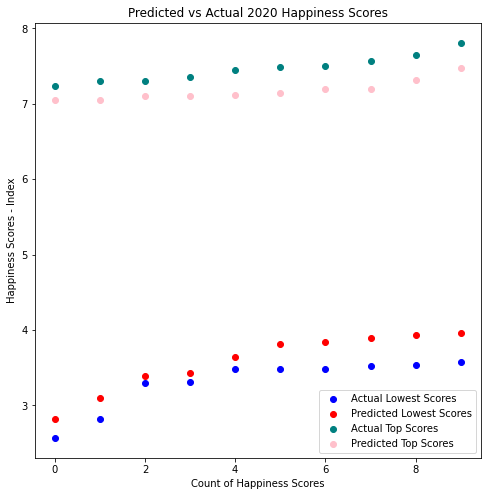

In [22]:
#Compare 2020 predictions with actual 2020 happiness scores

#Print actual 2020 happiness scores
happiness2020 = happiness.loc[happiness['year'] == 2020, 'happinessScore']
print('Actual Happiness Scores for Countries in 2020: \n', happiness2020.values.tolist(), '\n')
#Print actual top 10 happiness scores
realtop = np.sort(happiness2020)
realtop = realtop[-10:]
print('Countries with the top 10 actual happiness scores in 2020: \n', realtop, '\n')
#Print actual 10 lowest happiness scores
realbottom = np.sort(happiness2020)
realbottom = realbottom[:10]
print('Countries with the 10 lowest actual happiness scores in 2020: \n', realbottom, '\n')

#Plot the graph to visually compare 
plt.figure(figsize = (8,8))
plt.scatter(range(10), realbottom, color ='blue', label = 'Actual Lowest Scores')
plt.scatter(range(10), predbottom, color = 'red', label = 'Predicted Lowest Scores')
plt.scatter(range(10), realtop, color = 'teal', label = 'Actual Top Scores')
plt.scatter(range(10), predtop, color = 'pink', label = 'Predicted Top Scores')
plt.title('Predicted vs Actual 2020 Happiness Scores')
plt.xlabel('Count of Happiness Scores')
plt.ylabel('Happiness Scores - Index')
plt.legend()

I think the model did a decent job of predicting 2020 happiness scores. The model slightly underestimated the top happiness scores and slightly overestimated the lowest happiness scores but the margin of error is less than 0.5 units. When we look at the graph we can see that the actual and predicted values nearly coincide with eachother. 

In [29]:
##################### Classification ##########################################
#Decided to classify regions

#Reload & repeat cleaning process to add back in dropped predictors

#Load dataset into dataframe
happinessRaw2 = pd.read_csv('worldHapinness_2015_2020.csv')

#Review dataset
happinessRaw2.info()

#Check dataset for null values & drop null values
print('# of null values: ', happinessRaw2.isnull().sum().sum(), '\n')
happiness2 = happinessRaw2.dropna()

#Review dataset to ensure null values have been properly removed
print(happiness2.head(), '\n')
print('# of null values: ', happiness.isnull().sum().sum(), '\n')

#Rename feature labels
happiness2 = happiness2.rename(columns={'Regional indicator': 'Regional_Indicator'})
print('RENAMED: \n', happiness2.head(), '\n')

#Drop country column - don't want this data to influence how a region is classified b/c regions are defined by countries
happiness2 = happiness2.drop(['country'], axis = 1)
#Check to make sure remaining variables are int/floats
print(happiness2.info(), '\n')
print(happiness2.shape)

#Split happiness2 df into x & y
x = happiness2[happiness2.columns.difference(['Regional_Indicator'])]
y = happiness2['Regional_Indicator']

print(x, '\n', y, '\n')

#Split x and y into test and training datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             935 non-null    object 
 1   Regional indicator  933 non-null    object 
 2   happinessScore      935 non-null    float64
 3   GDPperCap           935 non-null    float64
 4   socialSupport       935 non-null    float64
 5   healthLE            935 non-null    float64
 6   freedom             935 non-null    float64
 7   generosity          935 non-null    float64
 8   trustGovernment     934 non-null    float64
 9   year                935 non-null    int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 73.2+ KB
# of null values:  3 

       country Regional indicator  happinessScore  GDPperCap  socialSupport  \
0      Finland     Western Europe           7.769      1.340          1.587   
1      Denmark     Western Europe           7.600      1.383   

[[14  1  0  1  2  0  0  0  0  0]
 [ 4  2  0  2  3  0  1  1  0  0]
 [ 6  1  0  1  0  0  0  0  0  1]
 [ 5  1  0 15  2  0  0  0  2  1]
 [ 4  1  0  1  8  0  0  0  5  2]
 [ 0  0  0  0  0  0  0  0  0  3]
 [ 1  1  0  0  0  0  1  4  3  0]
 [ 1  3  0  2  1  0  0  0  6  2]
 [ 0  1  0  1  0  0  2  0 44  0]
 [ 4  0  1  4  0  2  0  1  0 12]] 

                                    precision    recall  f1-score   support

        Central and Eastern Europe      0.359     0.778     0.491        18
Commonwealth of Independent States      0.182     0.154     0.167        13
                         East Asia      0.000     0.000     0.000         9
       Latin America and Caribbean      0.556     0.577     0.566        26
      Middle East and North Africa      0.500     0.381     0.432        21
             North America and ANZ      0.000     0.000     0.000         3
                        South Asia      0.250     0.100     0.143        10
                    Southeast Asia      0.000     0.000   

Text(32.999999999999986, 0.5, 'True Label')

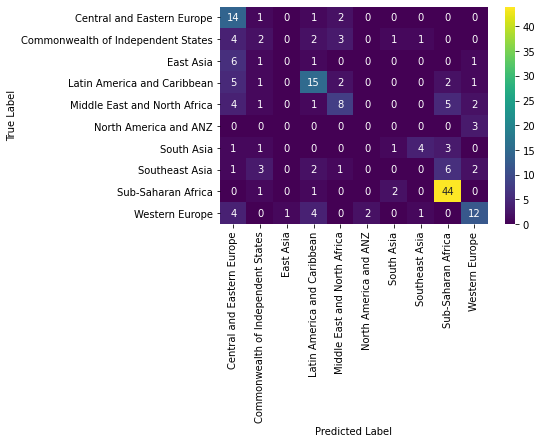

In [24]:
#Classification Model #1 - K-Nearest Neighbors

#Create K Neighbors Classifier
knn_happ = KNeighborsClassifier()

#Fit & train KNN model
knn_happ.fit(x_train, y_train)
y_predhap = knn_happ.predict(x_test)

#Print confusion matrix 
cm_happ = confusion_matrix(y_test, y_predhap) 
print(cm_happ, '\n')

#Print classification report
print(classification_report(y_test, y_predhap, digits = 3))

#Print pretty confusion matrix - visually see how well model predicted classifications 
regionList = set(happiness2['Regional_Indicator'].tolist())  #set() ensures unique values to create labels
regionList = ['Central and Eastern Europe', 'Commonwealth of Independent States', 'East Asia', 'Latin America and Caribbean',\
              'Middle East and North Africa', 'North America and ANZ', 'South Asia', 'Southeast Asia',  'Sub-Saharan Africa', \
              'Western Europe']   #reordered to match confusion matrix labels
plt.figure(figsize = (6,4))
sns.heatmap(cm_happ, annot = True, yticklabels = regionList, xticklabels = regionList, cmap = 'viridis')
plt.xticks(rotation = 90) 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

#Takeaway: overall accuracy is pretty low. Sub-Saharan Africa is the only region with a high precision
# and recall rate, which may be indiciative of the fact that it has the highest distribution in the sample.
# This sample has an uneven distribution of regions in the sample. 

In [25]:
#Use cross validation to determine the best number of neighbors to use in previous model

#Create empty list
accuracy = []

for i in range(1,30):      
    #Create a new KNN model
    KNN_cv = KNeighborsClassifier(n_neighbors = i)
    #Train model to get CV score
    cv_score = cross_val_score(KNN_cv, x_train, y_train, cv = 10)  
    #Print CV error (accuracy)
    print('# of Neighbors: ', i)
    print('Average of CV Scores: {}'.format(cv_score.mean()), '\n')
    #Save list of average mean scores 
    accuracy.append(cv_score.mean())
    
#Highest CV error is with a k-fold of 10, which corresponds to 4 neighbors 
print('CV Error: ', max(accuracy))

# of Neighbors:  1
Average of CV Scores: 0.4994594594594595 

# of Neighbors:  2
Average of CV Scores: 0.4497117117117118 

# of Neighbors:  3
Average of CV Scores: 0.5167927927927929 

# of Neighbors:  4
Average of CV Scores: 0.524918918918919 

# of Neighbors:  5
Average of CV Scores: 0.5208288288288289 

# of Neighbors:  6
Average of CV Scores: 0.5033333333333333 

# of Neighbors:  7
Average of CV Scores: 0.5033513513513513 

# of Neighbors:  8
Average of CV Scores: 0.5100720720720722 

# of Neighbors:  9
Average of CV Scores: 0.5020360360360361 

# of Neighbors:  10
Average of CV Scores: 0.5141441441441441 

# of Neighbors:  11
Average of CV Scores: 0.5154414414414414 

# of Neighbors:  12
Average of CV Scores: 0.5033153153153154 

# of Neighbors:  13
Average of CV Scores: 0.5059639639639639 

# of Neighbors:  14
Average of CV Scores: 0.49931531531531526 

# of Neighbors:  15
Average of CV Scores: 0.4993333333333333 

# of Neighbors:  16
Average of CV Scores: 0.48722522522522527 



[[13  2  0  1  2  0  0  0  0  0]
 [ 4  3  0  2  2  0  1  1  0  0]
 [ 5  1  0  1  0  0  0  0  0  2]
 [ 5  3  0 13  2  0  0  0  2  1]
 [ 3  2  0  1  7  0  0  0  6  2]
 [ 0  0  0  0  0  2  0  0  0  1]
 [ 2  0  0  0  0  0  1  4  3  0]
 [ 2  3  0  2  0  0  0  0  5  3]
 [ 0  0  0  2  0  0  1  0 45  0]
 [ 6  0  0  3  0  4  0  1  0 10]] 

                                    precision    recall  f1-score   support

        Central and Eastern Europe      0.325     0.722     0.448        18
Commonwealth of Independent States      0.214     0.231     0.222        13
                         East Asia      0.000     0.000     0.000         9
       Latin America and Caribbean      0.520     0.500     0.510        26
      Middle East and North Africa      0.538     0.333     0.412        21
             North America and ANZ      0.333     0.667     0.444         3
                        South Asia      0.333     0.100     0.154        10
                    Southeast Asia      0.000     0.000   

C:\Users\cakel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cakel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cakel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(32.999999999999986, 0.5, 'True Label')

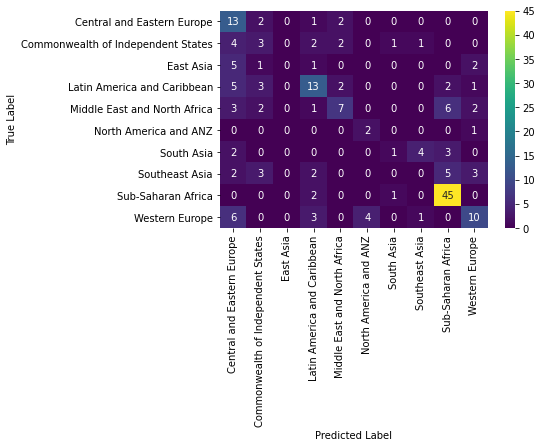

In [26]:
#Classification Model #1 - K-Nearest Neighbors with Optimal # of Neighbors

#With the optimal # of neighbors, refit & train the model

#Create K Neighbors Classifier set to optimal number of neighbors 
knn_happ = KNeighborsClassifier(n_neighbors = 4)

#Fit & train KNN model
knn_happ.fit(x_train, y_train)
y_predhap = knn_happ.predict(x_test)

#Print confusion matrix 
cm_happ = confusion_matrix(y_test, y_predhap)
print(cm_happ, '\n')

#Print clasification report
print(classification_report(y_test, y_predhap, digits = 3))

#Print pretty confusion matrix
plt.figure(figsize = (6,4))
sns.heatmap(cm_happ, annot = True, yticklabels = regionList, xticklabels = regionList, cmap = 'viridis')
plt.xticks(rotation = 90) 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

#Takeaway: Interestingly, the accuracy went down when including the optimal number of features. It appears
# that similar features are making it difficult for the KNN to succesfully predict regions. Some regions like
# North America & NZ were classified more correctly this time (granted, they only make up 3 records in the sample).

[[15  0  0  1  1  0  1  0  0  0]
 [ 1  4  0  4  1  0  1  1  1  0]
 [ 0  1  3  1  0  0  0  0  0  4]
 [ 7  1  0 14  1  0  1  0  2  0]
 [ 3  2  0  0  7  0  1  2  4  2]
 [ 0  0  0  0  0  2  0  0  0  1]
 [ 0  1  0  0  0  0  3  2  4  0]
 [ 0  0  0  3  0  0  1  6  2  3]
 [ 0  0  0  1  0  0  1  2 44  0]
 [ 0  1  4  0  0  4  0  0  0 15]] 

                                    precision    recall  f1-score   support

        Central and Eastern Europe      0.577     0.833     0.682        18
Commonwealth of Independent States      0.400     0.308     0.348        13
                         East Asia      0.429     0.333     0.375         9
       Latin America and Caribbean      0.583     0.538     0.560        26
      Middle East and North Africa      0.700     0.333     0.452        21
             North America and ANZ      0.333     0.667     0.444         3
                        South Asia      0.333     0.300     0.316        10
                    Southeast Asia      0.462     0.400   

Text(32.999999999999986, 0.5, 'True Label')

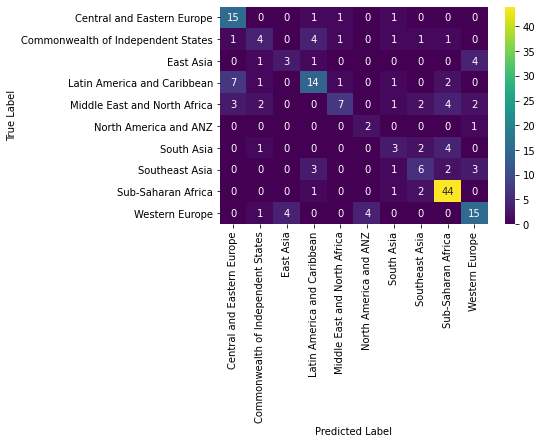

In [27]:
#Classification Model #2 - Naives Bayes 

#Create empty object of Naive Bayes
NB_model = GaussianNB()

#Feed data into model and fit and predict it
NBmodel_pred = NB_model.fit(x_train, y_train).predict(x_test)

#Calculate confusion matrix
NB_model_cm = confusion_matrix(y_test, NBmodel_pred)
print(NB_model_cm, '\n')

#Print out classification report
print(classification_report(y_test, NBmodel_pred, digits = 3))

#Print pretty confusion matrix
plt.figure(figsize = (6,4))
sns.heatmap(NB_model_cm, annot = True, yticklabels = regionList, xticklabels = regionList, cmap = 'viridis')
plt.xticks(rotation = 90) 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


In [28]:
#Compare accuracy scores of training & test data to confirm there is no overfitting
print('Training Set Accuracy Score: ', NB_model.score(x_train, y_train))
print('Test Set Accuracy Score: ', NB_model.score(x_test, y_test))

#Confirmed there is no overfitting as the test and training sets have comparable accuracy scores

Training Set Accuracy Score:  0.6013422818791946
Test Set Accuracy Score:  0.6042780748663101


The Naive Bayes model performed the best as evident by an improved accuracy score (albeit not the highest accuracy score) and general improvement in all scores compared to the previous KNN models. In previous KNN models, regions like East Asia and Southeast Asia were not correctly classified at all. These regions, in addition to South Asia and North America & ANZ, were particularly difficult to classfify across all models as indicative by low precision and recall rates. These regions may share overlapping features that make it dificult to differentiate the regions.

Overall, the Naive Bayes model performs an okay job of classifiying regions. With an accuracy rate of 60%, it's slightly better than a coin flip. 

In [ ]:
#References:
#https://www.kaggle.com/unsdsn/world-happiness
#Lab & Homework solutions
#My own homework & labs
#Intro to Statistical Learning (textbook)
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html
#https://www.geeksforgeeks.org./get-a-list-of-a-particular-column-values-of-a-pandas-dataframe/
#https://stackoverflow.com/questions/35277075/python-pandas-counting-the-occurrences-of-a-specific-value
#https://www.geeksforgeeks.org./ways-to-filter-pandas-dataframe-by-column-values/
#https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib
#https://www.kaggle.com/questions-and-answers/58368
#https://stackoverflow.com/questions/19071199/drop-columns-whose-name-contains-a-specific-string-from-pandas-dataframe
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
#https://realpython.com/linear-regression-in-python/
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
#https://numpy.org/doc/stable/reference/generated/numpy.sort.html
#https://www.geeksforgeeks.org./how-to-get-the-n-largest-values-of-an-array-using-numpy/
#https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
#https://datatofish.com/convert-pandas-dataframe-to-list/
#https://www.machinelearningplus.com/plots/python-scatter-plot/
#https://www.kite.com/python/answers/how-to-add-a-legend-to-a-matplotlib-plot-in-python
#https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/
#https://towardsdatascience.com/decoding-the-confusion-matrix-bb4801decbb
#https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-machine-learning-tips-and-tricks#classification-metrics
#https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85
#https://seaborn.pydata.org/tutorial/color_palettes.html
#https://stackoverflow.com/questions/27037241/changing-the-rotation-of-tick-labels-in-seaborn-heatmap
#https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
#https://uc-r.github.io/naive_bayes
#https://www.kaggle.com/prashant111/naive-bayes-classifier-in-python
#Prof GS lectures 